In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import rebound
import reboundx
%matplotlib inline

ODE
--

$R_1 = \alpha a_1^2 {\mu}_{2}{n_1}^2 (-b e_1 \cos{\phi_1} + c e_2 \cos{\phi_2})$

$R_2 = a_2^2 {\mu}_{1}{n_2}^2 (-b e_1 \cos{\phi_1} + c e_2 \cos{\phi_2})$

$\frac{d n_1}{dt} = 3 \alpha \mu_2 {n_1}^2 (b e_1 \sin{\phi_1} - c e_2 \sin{\phi_2}) + \frac{n_1}{\tau_{n1}} + \frac{3 n_1 {e_1}^2}{\tau_{e1}}$

$\frac{d n_2}{dt} = -6 \mu_1 {n_2}^2 (b e_1 \sin{\phi_1} - c e_2 \sin{\phi_2}) + \frac{n_2}{\tau_{n2}} + \frac{3 n_2 {e_2}^2}{\tau_{e2}}$

$\frac{d e_1}{dt} = \alpha b \mu_2 n_1 \sin{\phi_1} - \frac{e_1}{\tau_{e1}}$

$\frac{d e_2}{dt} = - c \mu_1 n_2 \sin{\phi_2} - \frac{e_2}{\tau_{e2}}$

$\frac{d\varpi_1}{dt} = - \alpha b \mu_2 n_1 \frac{\phi_1}{e_1}$

$\frac{d\varpi_2}{dt} = c \mu_1 n_2 \frac{\phi_2}{e_2}$

$\frac{d\sigma}{dt} = 2n_2 - n_1$


In [2]:
Degree_To_Rad = np.pi/180.
AU_To_Meter = 1.496e11
yr = 365*24*3600 # s
G = 6.6743e-11 # SI units
c_light = 3e8


m_Sun = 1.99e30 # solar mass in [kg]
R_Sun = 6.957e8 # solar radius in [m]
m_J = 1.898e27 # Jupiter mass in [kg]
R_J = 7.1492e7 # Jupiter radius in [m]
a_J = 7.78479e8 # Jupiter semi-major axis in [m]
m_E = 5.9722e24 # Earth mass in [kg]
R_E = 6.371e6 # Earth radius in [m]


k1 = 1.0 # m_star/m_Sun
m_Star = k1 * m_Sun
R_Star = k1 * R_Sun
R_sub = (k1**2) * 4 * R_Sun

k2 = 1.0 # m_planet/m_Jupiter
m_Planet = k2 * m_J

if k2 <= 0.41:
    R_Planet = R_E * (m_Planet/m_E)**(0.59) # low-mass planet; scale with Earth
else:
    R_Planet = R_J * k2**(-0.04) # massive planet; scale with Jupiter

k_ap = 10
a_Planet = k_ap * R_Sun # or R_Sun



In [3]:
alpha = 0.63 # a1/a2
b = 1.190
c = 0.428
mstar = 0.31 * m_Sun # in [kg]
mu1 = 9.7e-6
mu2 = 4.8e-5
tau_n1 = 2e5 * yr # in [s]
tau_n2 = 4e4 * yr # in [s]
tau_e1 = tau_n1/100.
tau_e2 = tau_n2/100.


In [4]:
def ode(R, t):
    n1, n2, e1, e2, pomega1, pomega2, sigma = R
    
    phi1 = sigma - pomega1
    phi2 = sigma - pomega2
    
    dn1dt = 3*alpha*mu2*(n1**2)*(b*e1*np.sin(phi1) - c*e2*np.sin(phi2)) + n1/tau_n1 + 3*n1*(e1**2)/tau_e1
    dn2dt = -6*mu1*(n2**2)*(b*e1*np.sin(phi1) - c*e2*np.sin(phi2)) + n2/tau_n2 + 3*n2*(e2**2)/tau_e2
    de1dt = alpha*b*mu2*n1*np.sin(phi1) - e1/tau_e1
    de2dt = -c*mu1*n2*np.sin(phi2) - e2/tau_e2
    dpomega1dt = -alpha*b*mu2*n1*np.cos(phi1)/e1
    dpomega2dt = c*mu1*n2*np.cos(phi2)/e2
    dsigmadt = 2*n2-n1
    
    dRdt=[dn1dt, dn2dt, de1dt, de2dt, dpomega1dt, dpomega2dt, dsigmadt]
    
    return dRdt 
    

In [5]:
a1 = 0.11 * AU_To_Meter
a2 = 0.18 * AU_To_Meter
n1_initial = np.sqrt(G*mstar/(a1**3))
n2_initial = np.sqrt(G*mstar/(a2**3))
e1_initial = 1e-3
e2_initial = 1e-3
pomega1_initial = 2*np.pi*np.random.rand()
pomega2_initial = 2*np.pi*np.random.rand()
sigma_initial = 2*np.pi*np.random.rand()

R0=[n1_initial, n2_initial, e1_initial, e2_initial, pomega1_initial, pomega2_initial, sigma_initial]
t=np.linspace(0, 20000*yr, 10000)
sol=odeint(ode, R0, t)


/Users/minliqiu/anaconda3/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [6]:
sol

array([[ 3.03965174e-06,  1.45212532e-06,  1.00000000e-03, ...,
         3.59915149e+00,  4.88045503e+00,  2.46286494e-01],
       [ 3.03970267e-06,  1.45219496e-06,  2.44248176e-03, ...,
         3.73724908e+00,  4.95317931e+00, -8.29191568e+00],
       [ 3.03972946e-06,  1.45226813e-06,  2.03485833e-03, ...,
         3.09803369e+00,  4.93534830e+00, -1.68232118e+01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

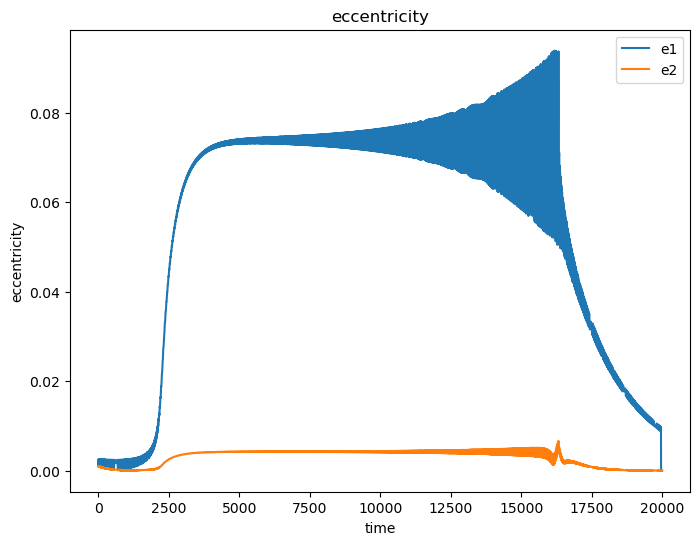

In [29]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
plt.title("eccentricity")
plt.xlabel("time")
plt.ylabel("eccentricity")
plt.plot(t/yr, sol[:, 2], label='e1')
plt.plot(t/yr, sol[:, 3], label='e2')
plt.legend()
plt.show()

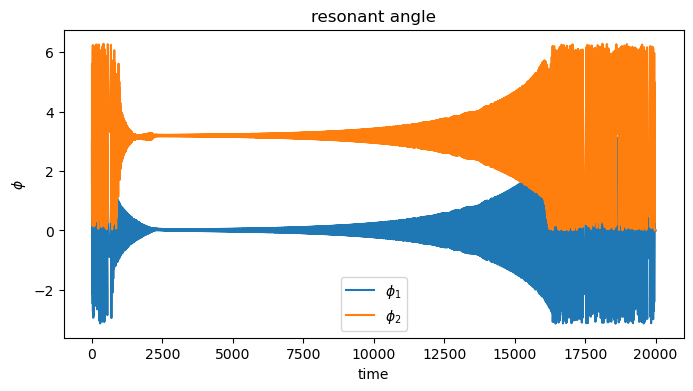

In [8]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
plt.title(r"resonant angle")
plt.xlabel("time")
plt.ylabel(r"$\phi$")
plt.plot(t/yr, (np.pi+sol[:, 6]-sol[:, 4])%(2*np.pi)-np.pi, label=r'$\phi_1$')
plt.plot(t/yr, (sol[:, 6]-sol[:, 5])%(2*np.pi), label=r'$\phi_2$')
plt.legend()
plt.show()

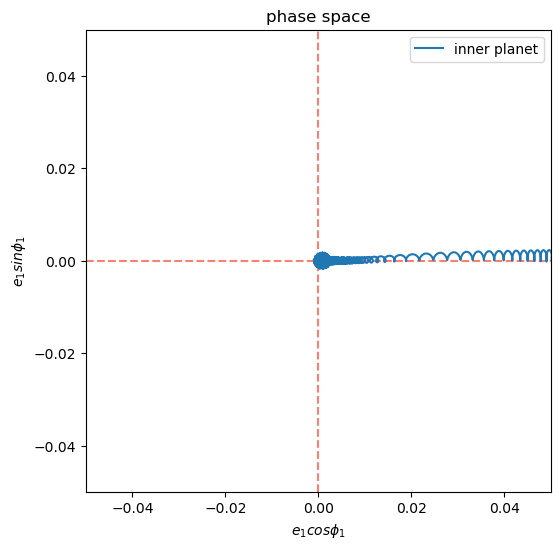

In [9]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
ax.set_xlim([-0.05, 0.05])
ax.set_ylim([-0.05, 0.05])
plt.title("phase space")
plt.xlabel(r"$e_1cos\phi_1$")
plt.ylabel(r"$e_1sin\phi_1$")
plt.axhline(y=0, linestyle='--', color='salmon')
plt.axvline(x=0, linestyle='--', color='salmon')
plt.plot((sol[0:2000, 2])*np.cos(sol[0:2000, 6]-sol[0:2000, 4]), (sol[0:2000, 2])*np.sin(sol[0:2000, 6]-sol[0:2000, 4]), label='inner planet')
plt.legend()
plt.show()

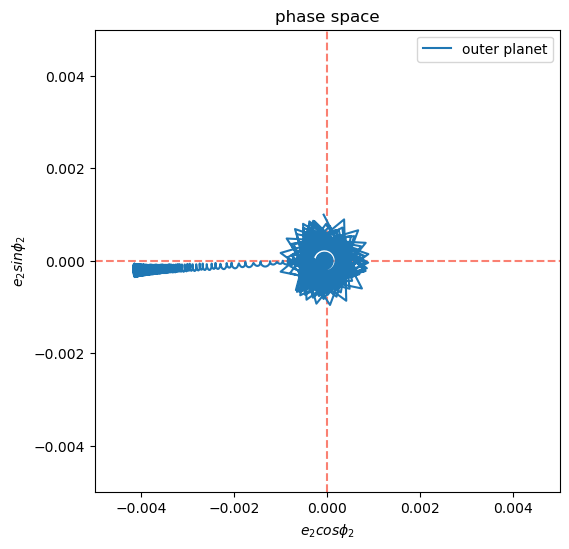

In [10]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
ax.set_xlim([-0.005, 0.005])
ax.set_ylim([-0.005, 0.005])
plt.title("phase space")
plt.xlabel(r"$e_2cos\phi_2$")
plt.ylabel(r"$e_2sin\phi_2$")
plt.axhline(y=0, linestyle='--', color='salmon')
plt.axvline(x=0, linestyle='--', color='salmon')
plt.plot((sol[0:2000, 3])*np.cos((sol[0:2000, 6]-sol[0:2000, 5])), (sol[0:2000, 3])*np.sin((sol[0:2000, 6]-sol[0:2000, 5])), label='outer planet')
plt.legend()
plt.show()

REBOUND
--

In [11]:
sim = rebound.Simulation()
sim.integrator = "ias15"
sim.units = ('m', 's', 'kg')
sim.G = 6.674e-11 # SI units
sim.dt = 1e1 # Initial timestep in sec.

mu1 = 9.7e-6
mu2 = 4.8e-5
a1 = 0.11 * AU_To_Meter
a2 = 0.18 * AU_To_Meter

sim.add(m=mstar, hash="Star") # add Sun with mass in kg
sim.add(m=mu1*mstar, a=a1, hash="Planet_1")
sim.move_to_com()
sim.add(m=mu2*mstar, a=a2, hash="Planet_2")

ps = sim.particles

sim.status()


---------------------------------
REBOUND version:     	3.24.0
REBOUND built on:    	Mar 28 2023 02:54:30
Number of particles: 	3
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	10.000000
---------------------------------
<rebound.particle.Particle object at 0x7f96f06e85c0, m=6.169e+29 x=-159621.65166997878 y=0.0 z=0.0 vx=0.0 vy=-0.4851856805313849 vz=0.0>
<rebound.particle.Particle object at 0x7f96f06e8e40, m=5.98393e+24 x=16455840378.34833 y=0.0 z=0.0 vx=0.0 vy=50019.14232282319 vz=0.0>
<rebound.particle.Particle object at 0x7f96f06e85c0, m=2.96112e+25 x=26928000000.0 y=0.0 z=0.0 vx=0.0 vy=39103.07995876342 vz=0.0>
---------------------------------


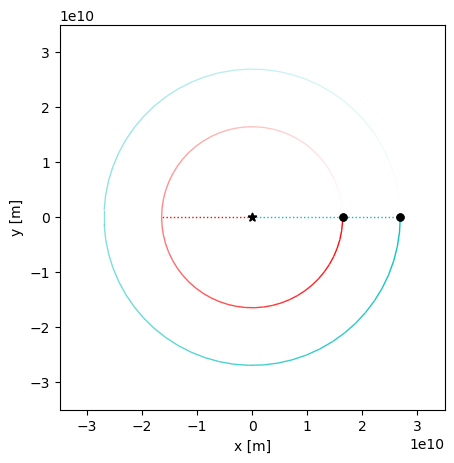

In [12]:
op = rebound.OrbitPlot(sim, unitlabel="[m]", color=True, periastron=True)

In [13]:
rebx = reboundx.Extras(sim)
mof = rebx.load_force("modify_orbits_forces") # orbit-averaged
rebx.add_force(mof)

In [14]:
tau_n1 = 2e5 * yr # in [s]
tau_n2 = 4e4 * yr # in [s]
tau_e1 = tau_n1/100.
tau_e2 = tau_n2/100.

ps["Planet_1"].params["tau_a"] = -1.5 * tau_n1
ps["Planet_1"].params["tau_e"] = -tau_e1
ps["Planet_2"].params["tau_a"] = -1.5 * tau_n2
ps["Planet_2"].params["tau_e"] = -tau_e2


In [15]:
%%time

yr = 365*24*3600 # s

Noutput = 5000
times = np.linspace(0, 20000*yr, Noutput)

e_1, a_1, n_1, kappa_1, resonant_angle_1 = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)
e_2, a_2, n_2, kappa_2, resonant_angle_2 = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)


for i, time in enumerate(times):
    sim.integrate(time)
    
    e_1[i], a_1[i], n_1[i] = ps["Planet_1"].e, ps["Planet_1"].a, ps["Planet_1"].n
    resonant_angle_1[i] = 2*ps["Planet_2"].l -  ps['Planet_1'].l - ps['Planet_1'].pomega
    e_2[i], a_2[i], n_2[i] = ps["Planet_2"].e, ps["Planet_2"].calculate_orbit().a, ps["Planet_2"].calculate_orbit().n
    resonant_angle_2[i] = 2*ps["Planet_2"].l -  ps['Planet_1'].l - ps['Planet_2'].pomega
#     kappa2[i] = (2-ps["Planet_1"].calculate_orbit().n/ps["Planet_2"].calculate_orbit().n) + 6*e1[i]**2



CPU times: user 2min 48s, sys: 535 ms, total: 2min 49s
Wall time: 2min 48s


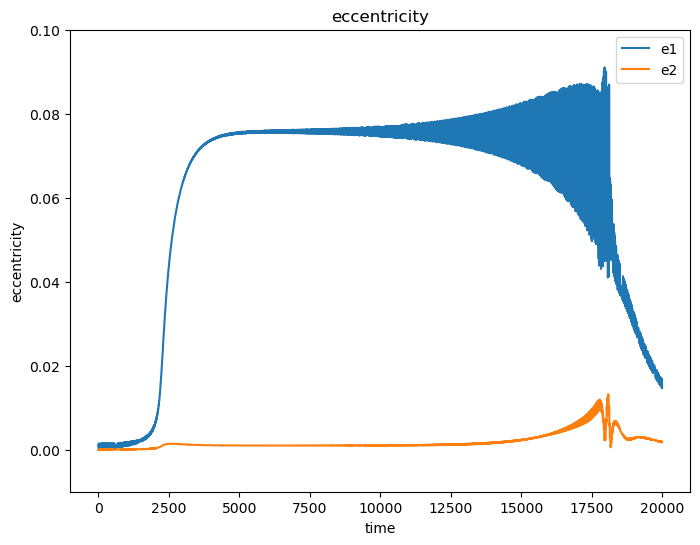

In [32]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.set_ylim([-0.01, 0.1])
plt.title("eccentricity")
plt.xlabel("time")
plt.ylabel("eccentricity")
plt.plot(times/yr, e_1, label='e1')
plt.plot(times/yr, e_2, label='e2')
plt.legend()
plt.show()

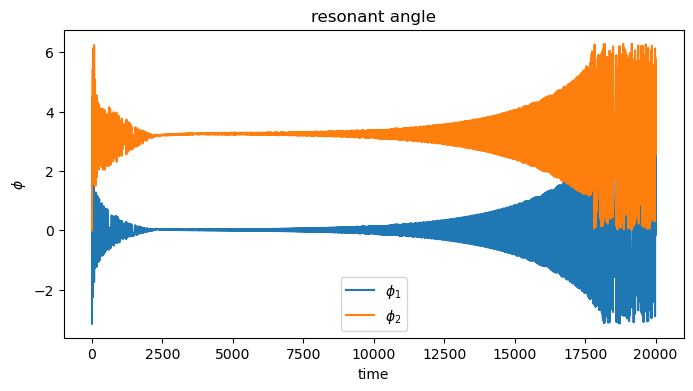

In [33]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
plt.title("resonant angle")
plt.xlabel("time")
plt.ylabel(r"$\phi$")
plt.plot(times/yr, (np.pi+resonant_angle_1)%(2*np.pi)-np.pi, label=r'$\phi_1$')
plt.plot(times/yr, resonant_angle_2%(2*np.pi), label=r'$\phi_2$')
plt.legend()
plt.show()

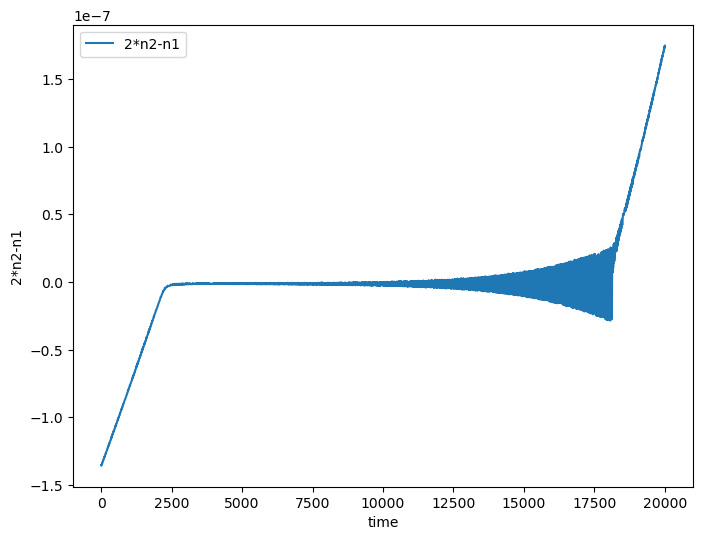

In [18]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
plt.xlabel("time")
plt.ylabel("2*n2-n1")
plt.plot(times/yr, 2*n_2-n_1, label='2*n2-n1')
plt.legend()
plt.show()

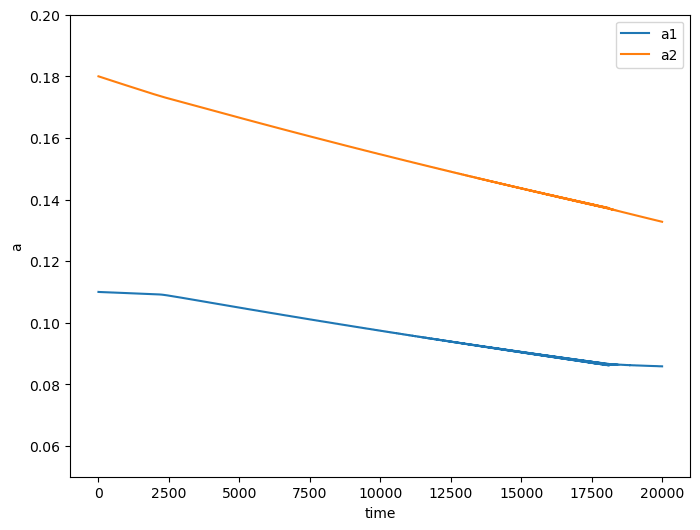

In [19]:
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
# ax.set_xlim([-2.5,1.5])
ax.set_ylim([0.05, 0.2])
plt.xlabel("time")
plt.ylabel("a")
plt.plot(times/yr, a_1/AU_To_Meter, label='a1')
plt.plot(times/yr, a_2/AU_To_Meter, label='a2')
plt.legend()
plt.show()

phase space
--

In [20]:
ecosphi1 = e_1*np.cos(resonant_angle_1)
esinphi1 = e_1*np.sin(resonant_angle_1)

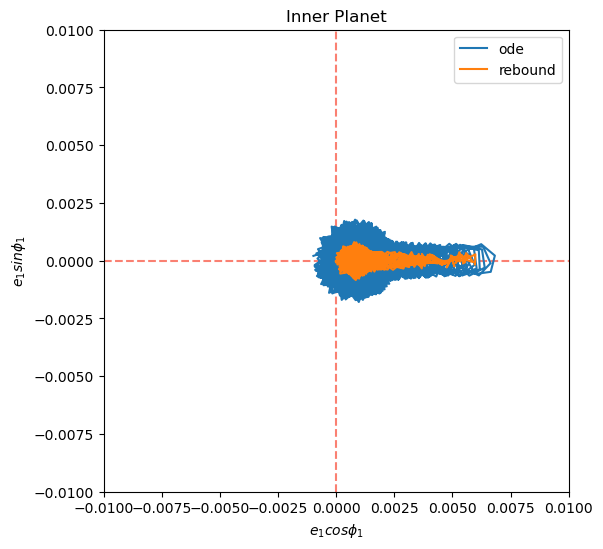

In [21]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
ax.set_xlim([-0.01, 0.01])
ax.set_ylim([-0.01, 0.01])
plt.title('Inner Planet')
plt.xlabel(r"$e_1cos\phi_1$")
plt.ylabel(r"$e_1sin\phi_1$")
plt.axhline(y=0, linestyle='--', color='salmon')
plt.axvline(x=0, linestyle='--', color='salmon')
plt.plot((sol[0:1000, 2])*np.cos(sol[0:1000, 6]-sol[0:1000, 4]), (sol[0:1000, 2])*np.sin(sol[0:1000, 6]-sol[0:1000, 4]), label='ode')
plt.plot(ecosphi1[0:500], esinphi1[0:500], label='rebound')
plt.legend()
plt.show()

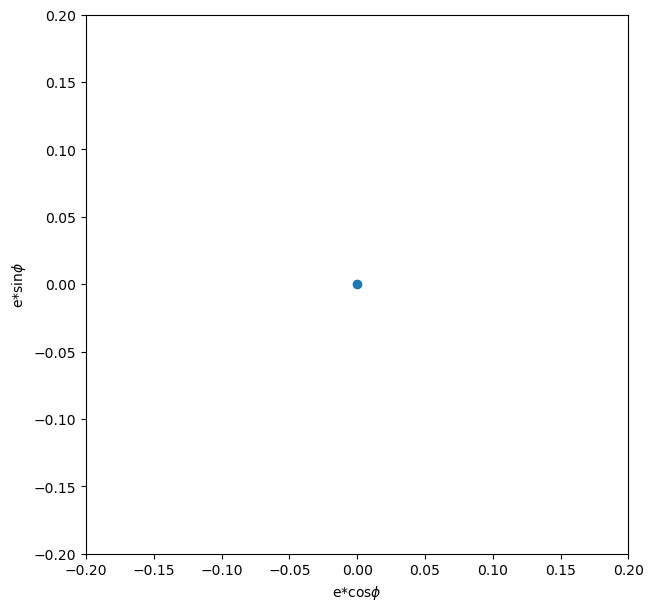

In [22]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.set_xlabel(r"e*cos$\phi$")
ax.set_ylabel(r"e*sin$\phi$")

points, = ax.plot(ecosphi1[0], esinphi1[0], 'o-', markevery=[-1])

trail=30

def animate(i, trail=30):
    points.set_data(ecosphi1[i-trail:i], esinphi1[i-trail:i])
    return points, # time_text, para_text
    
        
ani = animation.FuncAnimation(fig, animate, len(ecosphi1), fargs=(trail,), interval=150) # len(xyzs)
# ani.save('animation_phase4.mp4')
plt.show()



In [23]:
from IPython.display import HTML

HTML(ani.to_html5_video())

In [24]:
ecosphi2 = e_2*np.cos(resonant_angle_2)
esinphi2 = e_2*np.sin(resonant_angle_2)

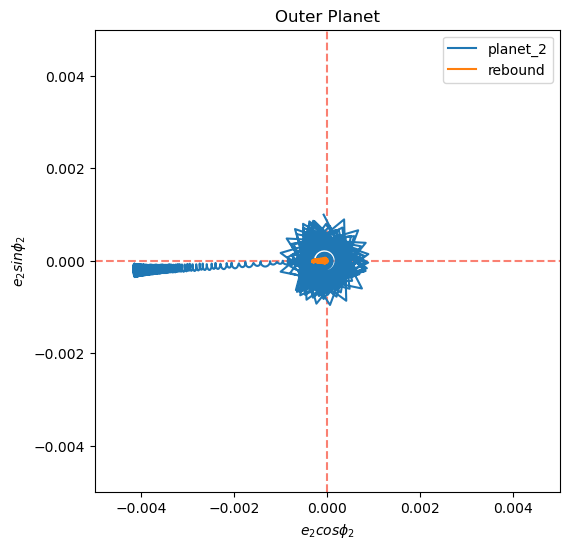

In [25]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
ax.set_xlim([-0.005, 0.005])
ax.set_ylim([-0.005, 0.005])
plt.title('Outer Planet')
plt.xlabel(r"$e_2cos\phi_2$")
plt.ylabel(r"$e_2sin\phi_2$")
plt.axhline(y=0, linestyle='--', color='salmon')
plt.axvline(x=0, linestyle='--', color='salmon')
plt.plot((sol[0:2000, 3])*np.cos(sol[0:2000, 6]-sol[0:2000, 5]), (sol[0:2000, 3])*np.sin(sol[0:2000, 6]-sol[0:2000, 5]), label='planet_2')
plt.plot(ecosphi2[0:500], esinphi2[0:500], label='rebound')
plt.legend()
plt.show()

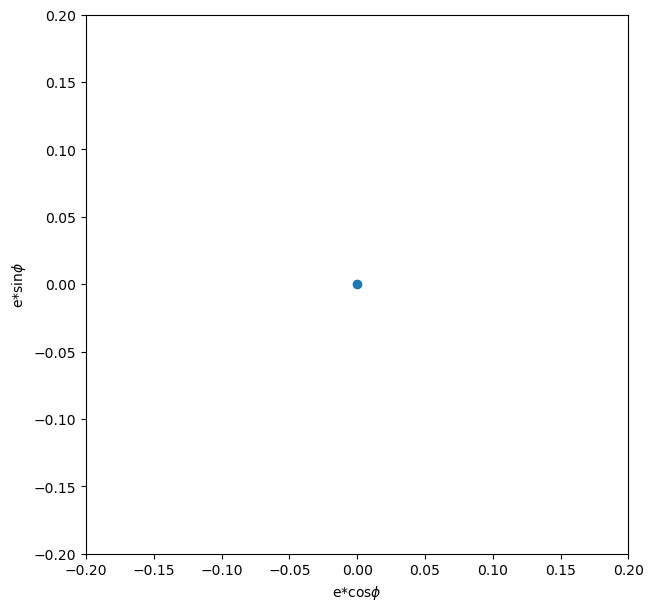

In [26]:
import matplotlib.animation as animation


fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111)
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-0.2, 0.2)
ax.set_xlabel(r"e*cos$\phi$")
ax.set_ylabel(r"e*sin$\phi$")

points, = ax.plot(ecosphi2[0], esinphi2[0], 'o-', markevery=[-1])

trail=30

def animate(i, trail=30):
    points.set_data(ecosphi2[i-trail:i], esinphi1[i-trail:i])
    return points,
    
        
ani = animation.FuncAnimation(fig, animate, len(ecosphi2), fargs=(trail,), interval=150) # len(xyzs)
# ani.save('animation_phase4.mp4')
plt.show()




In [27]:
from IPython.display import HTML

HTML(ani.to_html5_video())